##Entropy view

This notebook can be used to compare the change in the internal state between two prompts

In [1]:
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from generate_entropys import calculate_attention_entropy, get_df, get_attention, get_token_input_ids
from transformers import AutoModelForCausalLM, AutoTokenizer
from figures import create_heat_map_for_df,create_heat_map_for_tensor,create_hist_for_df,create_hist_for_tensor
from utils import print_cuda_info

layer_start = 0
layer_end = None

task = "Is this true? Only yes or no!"
a_prompt = task + "George Washington was the first president of the United States of America."
#a_prompt = task + "Issaac Asimov wrote a book called Nightfall."
b_prompt = task + "Issaac Asimov wrote a book called Daybreak."

model_id = 'google/gemma-2-27b-it'

xlim = None# (0,1)
ylim = None #(0, 2000)

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
print_cuda_info()

/home/knowledgeconflict/.local/share/virtualenvs/MasterThesis-5ARcKmzf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB
True
CUDA_VISIBLE_DEVICES:  1,2


In [2]:
#init model compontens
tokenizer = AutoTokenizer.from_pretrained(model_id,device_map="auto")
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True,device_map="auto")
print(model.device)

Loading checkpoint shards: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]


cuda:0


In [3]:
#get internal state 
a_attention, a_decoded_text = get_attention(prompt=a_prompt,model=model,tokenizer=tokenizer)
b_attention, b_decoded_text = get_attention(prompt=b_prompt,model=model,tokenizer=tokenizer)

In [4]:
#shape
print(a_attention.shape)
print(b_attention.shape)
#answers
print(a_decoded_text)
print(b_decoded_text)
#tokens
print(get_token_input_ids(prompt=a_prompt,tokenizer=tokenizer))
print(get_token_input_ids(prompt=b_prompt,tokenizer=tokenizer))

torch.Size([46, 1, 32, 23, 23])
torch.Size([46, 1, 32, 22, 22])
<bos>Is this true? Only yes or no!George Washington was the first president of the United States of America.

Answer: Yes.<end_of_turn>
<eos>
<bos>Is this true? Only yes or no!Issaac Asimov wrote a book called Daybreak.

Yes.<end_of_turn>
<eos>
(['<bos>', 'Is', '▁this', '▁true', '?', '▁Only', '▁yes', '▁or', '▁no', '!', 'George', '▁Washington', '▁was', '▁the', '▁first', '▁president', '▁of', '▁the', '▁United', '▁States', '▁of', '▁America', '.'], {'input_ids': tensor([[     2,   2437,    736,   1382, 235336,   8786,   7778,    689,    793,
         235341,  21175,   7049,    729,    573,   1370,   9456,    576,    573,
           3520,   3858,    576,   5783, 235265]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')})
(['<bos>', 'Is', '▁this', '▁true', '?', '▁Only', '▁yes', '▁or', '▁no', '!', 'I', 'ssa', 'ac', '▁A', 'simov', '▁wrote', 

In [5]:
def caculate_entropy(attention):
    return -torch.sum(attention * torch.log(attention + 1e-9), dim=-1) / torch.log(torch.tensor(attention.shape[-1]))

def calculate_mean(attention):
    return torch.mean(attention,-1)

def calculate_std(attention):
    return torch.std(attention,dim=-1)

def calculate_var(attention):
    return torch.var(attention,dim=-1)

def idx_of_dispersion(attention):
    return calculate_var(attention) / calculate_mean(attention)

def coef_of_variation(attention):
    return calculate_std(attention) / calculate_mean(attention)



In [6]:
def remove_bos_info(tensor):
    tensor = tensor[:,:,:,1:,:]
    tensor = tensor[:,:,:,:,1:]
    return tensor

In [7]:
#preprocess
a_attention = a_attention.cpu()
b_attention = b_attention.cpu()


#layer selection
a_attention = a_attention[layer_start:layer_end] 
b_attention = b_attention[layer_start:layer_end]

#token selection
#a_attention = a_attention[:,:,:,-1]
#b_attention = b_attention[:,:,:,-1]

#remove bos 
a_attention = remove_bos_info(a_attention)
b_attention = remove_bos_info(b_attention)

In [8]:

def create_hists_for_func(a_attention,b_attention,func, title_appendix=""):
    a = func(a_attention)
    b = func(b_attention)
    print(a.shape)
    print(b.shape)

    create_hist_for_tensor(a,title="a_"+title_appendix,xlim=xlim,ylim=ylim)
    create_hist_for_tensor(b,title="b_"+title_appendix,xlim=xlim,ylim=ylim)

    print("comparing means") 
    print(torch.mean(a))
    print(torch.mean(b))

def create_heatmap_for_func(a_attention,b_attention,func, title_appendix=""):
    a = func(a_attention)
    b = func(b_attention)
    a_avg_token = torch.squeeze(torch.mean(a,dim=-1))
    b_avg_token = torch.squeeze(torch.mean(b,dim=-1))
    print(a.shape)
    print(b.shape)
    create_heat_map_for_tensor(a_avg_token,title="a_"+title_appendix)
    create_heat_map_for_tensor(b_avg_token,title="b_"+title_appendix)

    distance_tensor = a_avg_token - b_avg_token 
    distance_tensor = distance_tensor.abs()
    create_heat_map_for_tensor(distance_tensor,title="dist_"+title_appendix)



torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


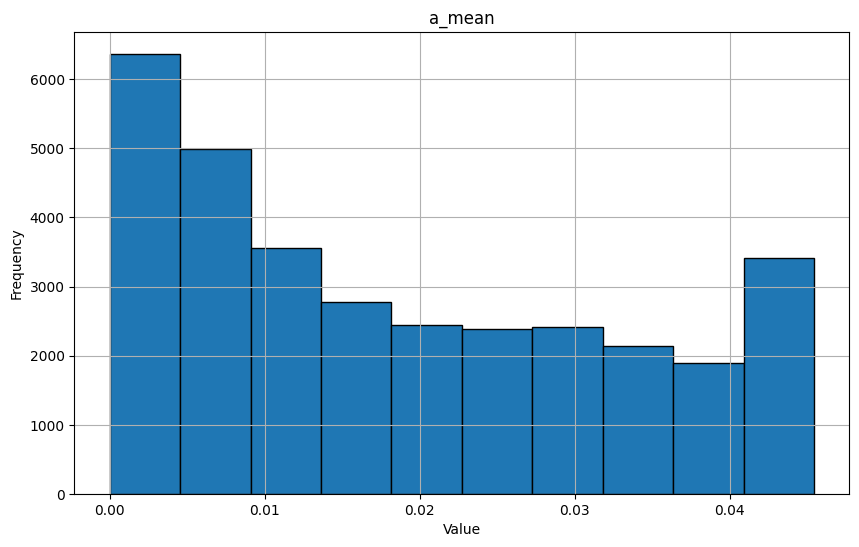

<Figure size 640x480 with 0 Axes>

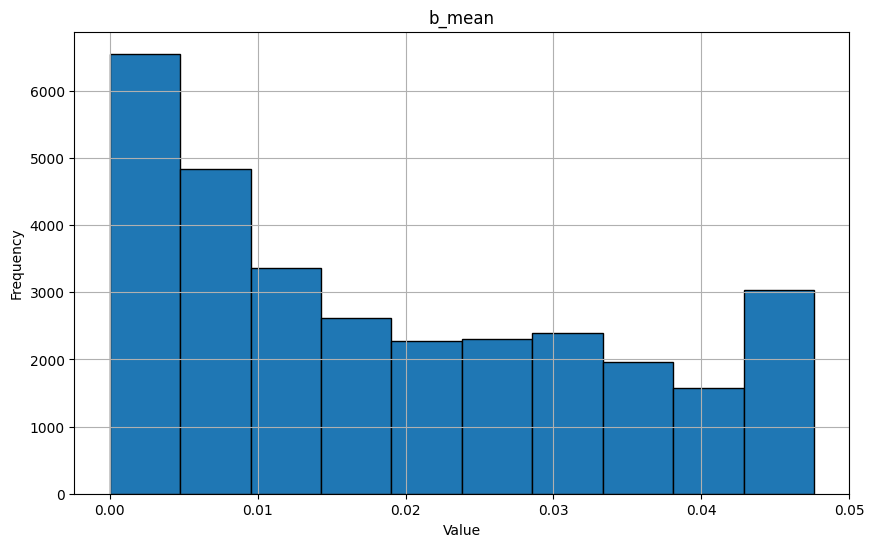

comparing means
tensor(0.0187)
tensor(0.0189)
torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


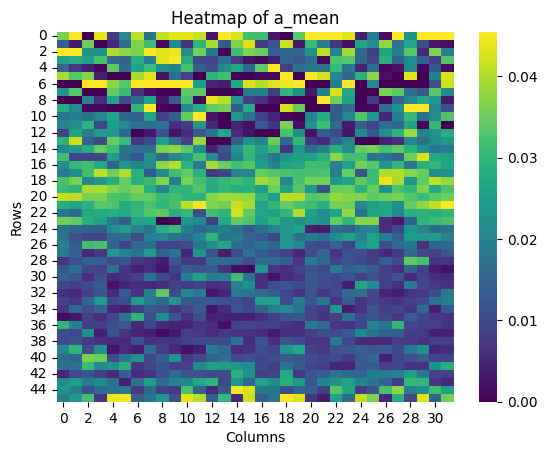

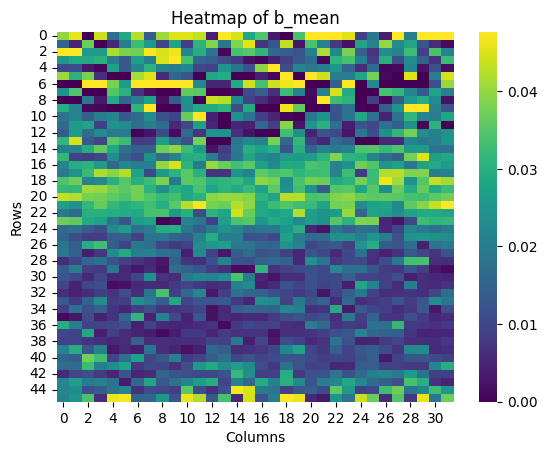

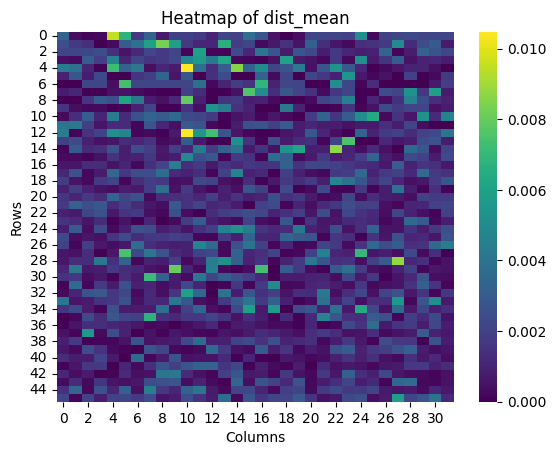

In [9]:
create_hists_for_func(a_attention,b_attention,func=calculate_mean,title_appendix="mean")
create_heatmap_for_func(a_attention,b_attention,func=calculate_mean,title_appendix="mean")

torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


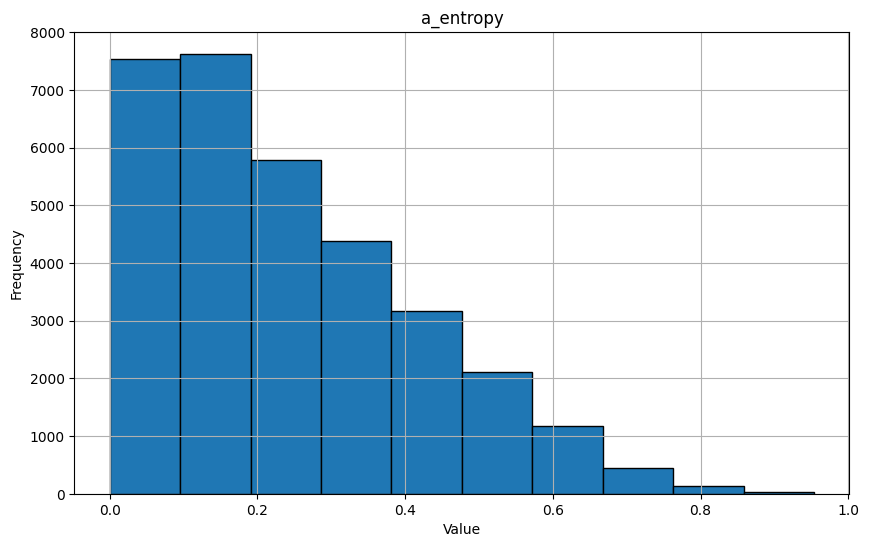

<Figure size 640x480 with 0 Axes>

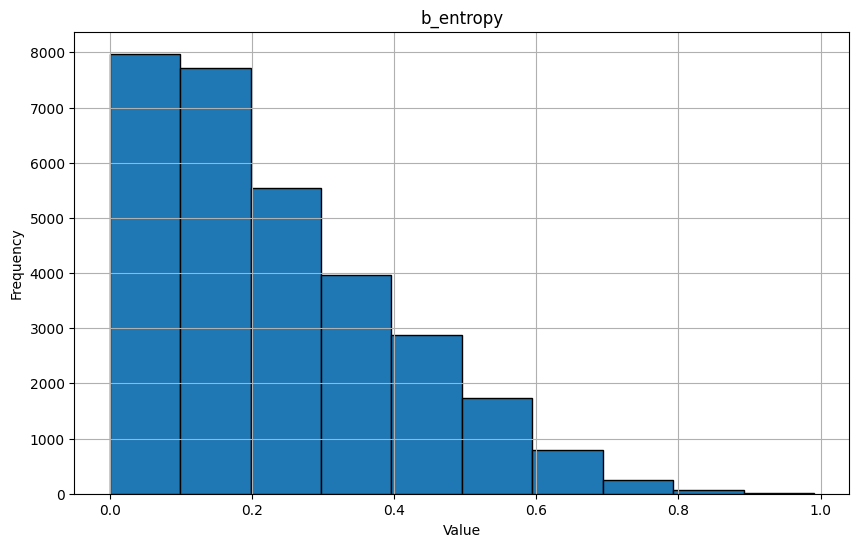

comparing means
tensor(0.2404)
tensor(0.2303)
torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


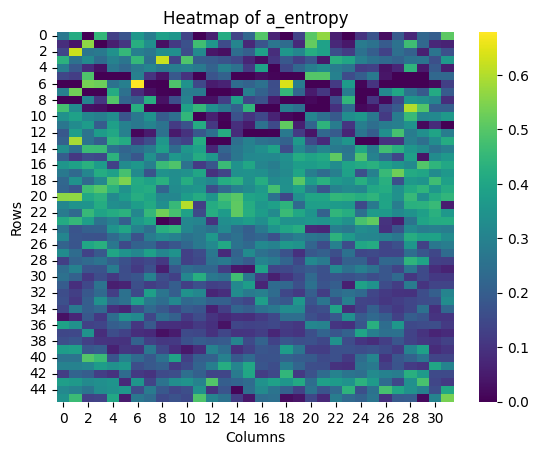

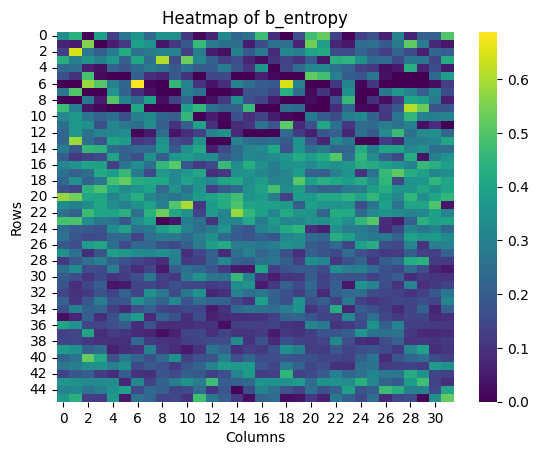

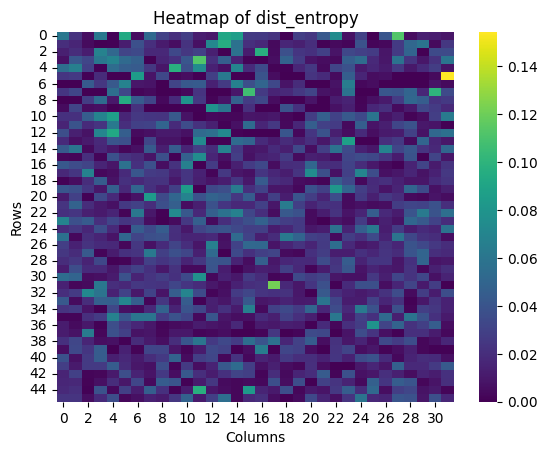

In [10]:
create_hists_for_func(a_attention,b_attention,func=caculate_entropy,title_appendix="entropy")
create_heatmap_for_func(a_attention,b_attention,func=caculate_entropy,title_appendix="entropy")

torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


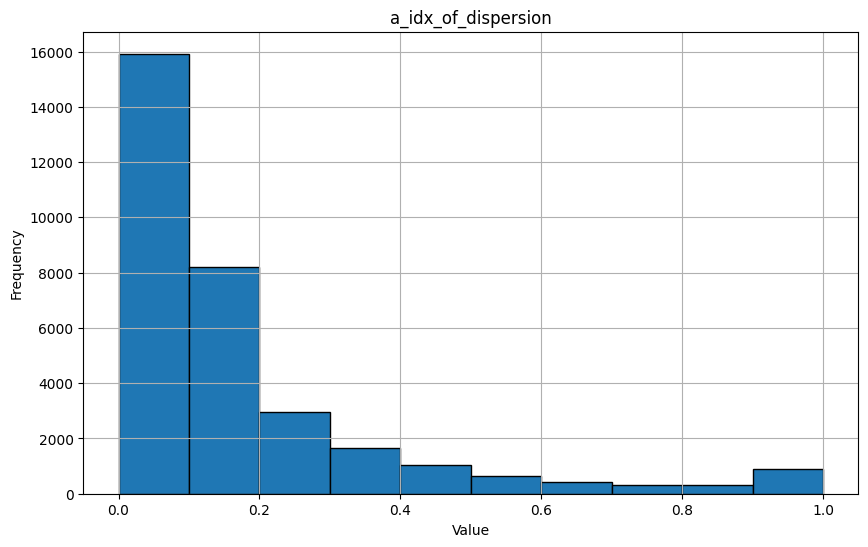

<Figure size 640x480 with 0 Axes>

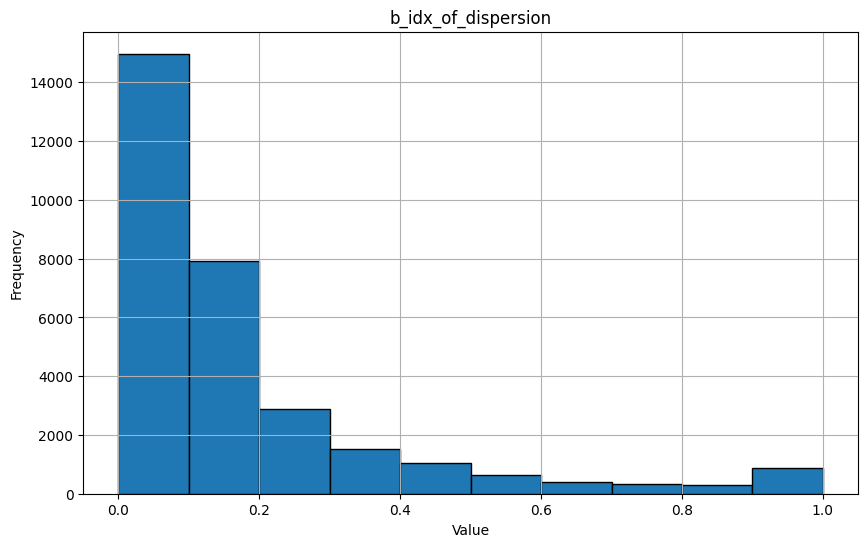

comparing means
tensor(0.1737)
tensor(0.1762)
torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


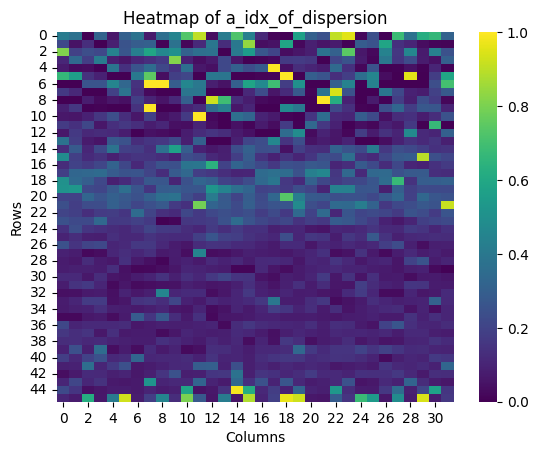

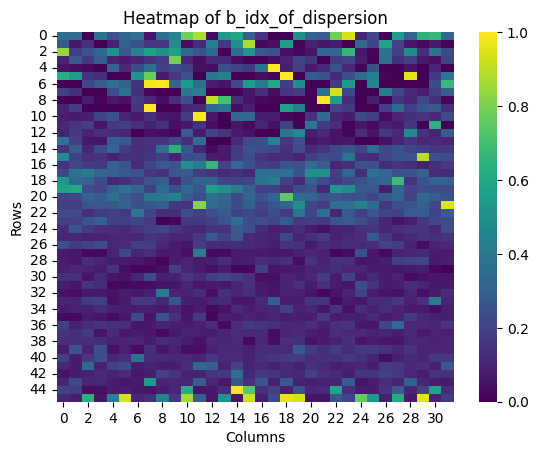

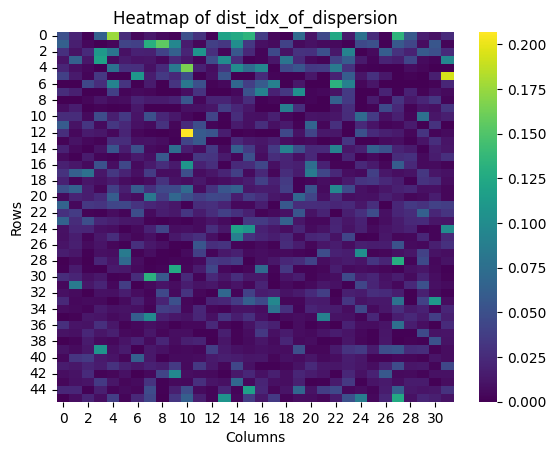

In [11]:
create_hists_for_func(a_attention,b_attention,func=idx_of_dispersion,title_appendix="idx_of_dispersion")
create_heatmap_for_func(a_attention,b_attention,func=idx_of_dispersion,title_appendix="idx_of_dispersion")

torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


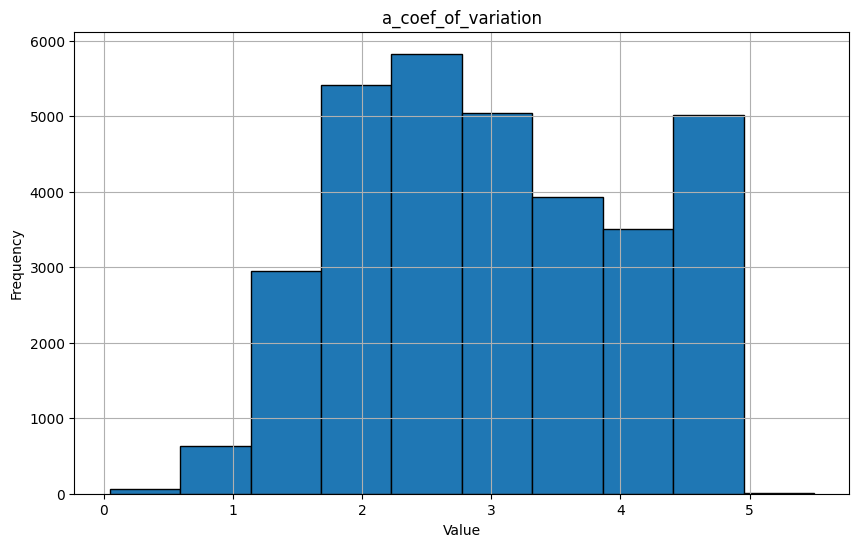

<Figure size 640x480 with 0 Axes>

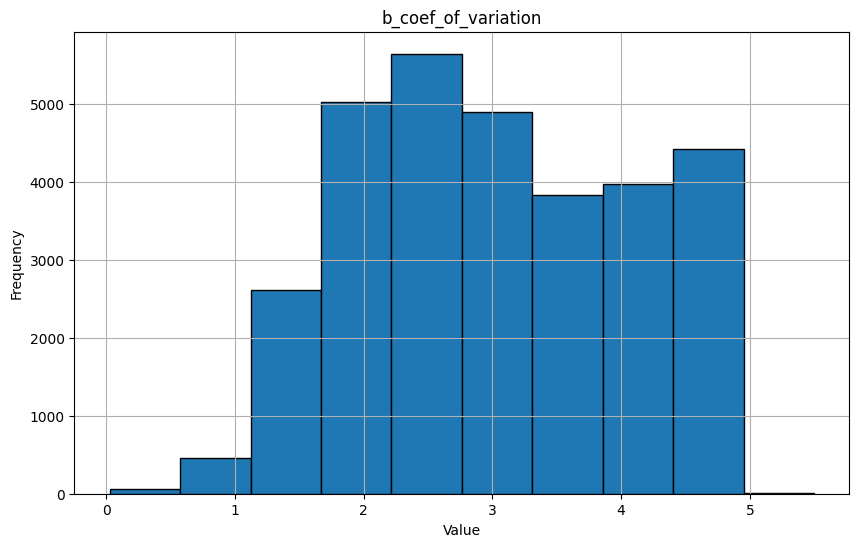

comparing means
tensor(3.0044)
tensor(3.0148)
torch.Size([46, 1, 32, 22])
torch.Size([46, 1, 32, 21])


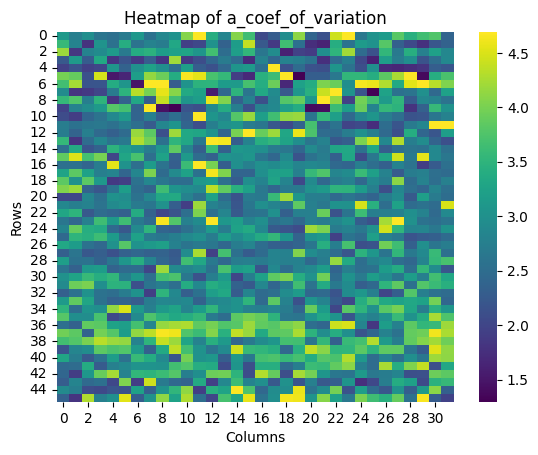

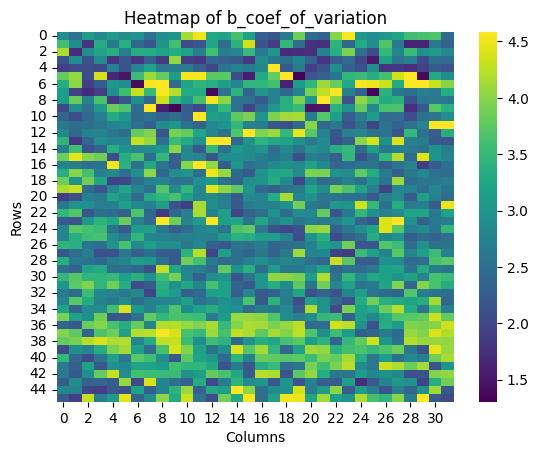

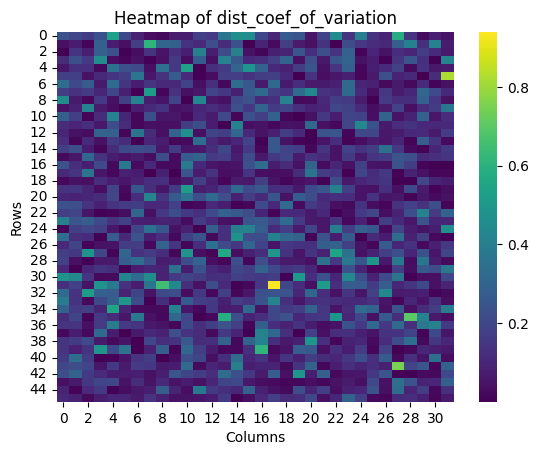

In [12]:
create_hists_for_func(a_attention,b_attention,func=coef_of_variation,title_appendix="coef_of_variation")
create_heatmap_for_func(a_attention,b_attention,func=coef_of_variation,title_appendix="coef_of_variation")